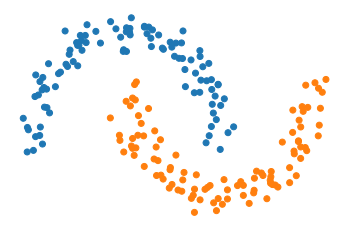

Epoch 1/8
30/30 [==============================] - 7s 240ms/step - loss: 0.4827 - accuracy: 0.5533 - val_loss: 0.4549 - val_accuracy: 0.7000
Epoch 2/8
30/30 [==============================] - 7s 246ms/step - loss: 0.3547 - accuracy: 0.7867 - val_loss: 0.3364 - val_accuracy: 0.7000
Epoch 3/8
30/30 [==============================] - 7s 243ms/step - loss: 0.2384 - accuracy: 0.8200 - val_loss: 0.2618 - val_accuracy: 0.8200
Epoch 4/8
30/30 [==============================] - 8s 264ms/step - loss: 0.1883 - accuracy: 0.8400 - val_loss: 0.2188 - val_accuracy: 0.8600
Epoch 5/8
30/30 [==============================] - 8s 260ms/step - loss: 0.1617 - accuracy: 0.8733 - val_loss: 0.1924 - val_accuracy: 0.8800
Epoch 6/8
30/30 [==============================] - 8s 261ms/step - loss: 0.1497 - accuracy: 0.8800 - val_loss: 0.1759 - val_accuracy: 0.8800
Epoch 7/8
30/30 [==============================] - 8s 266ms/step - loss: 0.1370 - accuracy: 0.8800 - val_loss: 0.2066 - val_accuracy: 0.7800
Epoch 8/8
30/

In [1]:
r"""
Hybrid quantum-classical ML using Keras and PyTorch
===================================================

.. meta::
    :property="og:description": TODO
    :property="og:image": TODO

In PennyLane, variational quantum circuits are treated as :doc:`quantum nodes
<../glossary/hybrid_computation>` (QNodes) that can be thought of simply as functions with a
defined output and gradient for a given input. QNodes can be combined with classical nodes to
form a hybrid model, which can be trained using the TensorFlow, PyTorch or Autograd/NumPy
:doc:`interfaces <introduction/interfaces>`.

Composing computational nodes is a fundamental tool of any machine learning package. However,
it is often useful to have access to additional high-level functionality for model construction
and training. TensorFlow and PyTorch both provide a high-level API for creating neural networks:
TensorFlow integrates with `Keras <https://keras.io/>`__ while PyTorch includes a
`torch.nn <https://pytorch.org/docs/stable/nn.html>`__ module.

This tutorial shows how QNodes in PennyLane can be interfaced with `Keras <https://keras.io/>`__ and
`torch.nn <https://pytorch.org/docs/stable/nn.html>`__ to provide a high-level approach to
creating hybrid quantum-classical models.

Fixing the dataset and problem
------------------------------

Let us begin by choosing a simple dataset and problem to allow us to focus on how the hybrid
model is constructed. Our objective is to classify points generated from scikit-learn's
`make_moons() <https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html>`__ dataset:
"""

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import tensorflow as tf

X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ['#1f77b4' if y_ == 0 else '#ff7f0e' for y_ in y]
plt.axis('off')
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

###############################################################################
# Defining a QNode
# ----------------
#
# Our next step is to define the QNode that we want to interface with `Keras <https://keras.io/>`__
# or `torch.nn <https://pytorch.org/docs/stable/nn.html>`__. Any combination of device, operations
# and measurements that is valid in PennyLane can be used to compose the QNode. However,
# the QNode arguments must satisfy additional
# `conditions <https://pennylane.readthedocs.io/en/stable/code/api/pennylane.qnn.KerasLayer.html#usageDetails>`__
# including having an argument called ``inputs``. All other arguments must be arrays or tensors
# and are treated as trainable weights in the model. We fix a two-qubit QNode using the
# :doc:`default.qubit <code/api/pennylane.plugins.default_qubit.DefaultQubit>` simulator and
# operations from the :doc:`templates <introduction/templates>` module.

import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

###############################################################################
# Note that we do not need to specify the ``interface`` argument in the :func:`~pennylane.qnode`
# decorator.
#
# Interfacing with Keras and Torch
# --------------------------------
#
# With the QNode defined, we are nearly ready to interface with `Keras <https://keras.io/>`__ or
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__. This is achieved using the
# :class:`~pennylane.qnn.KerasLayer` and :class:`~pennylane.qnn.TorchLayer` classes of the
# :mod:`~pennylane.qnn` module, which convert the QNode to the elementary building block of these
# high-level frameworks: a *layer*. We shall see in the following how the resultant layer can be
# combined with other well-known neural network layers to form a hybrid model.
#
# Before doing this, we must first define the ``weight_shapes`` dictionary. Recall that all of
# the arguments of the QNode except for the ``inputs``-named argument are treated as trainable
# weights. For the QNode to be successfully converted to a layer in `Keras <https://keras.io/>`__ or
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__, we need to provide the details of the
# shape of each trainable weight for them to be initialized. The ``weight_shapes`` dictionary
# maps from the argument names of the QNode to corresponding weights:

n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

###############################################################################
# In our example, the ``weights`` argument of the QNode is trainable and has shape given by
# ``(n_layers, n_qubits, 3)`` which are passed to
# :func:`~pennylane.templates.layers.StronglyEntanglingLayers`.
#
# With ``weight_shapes`` defined, it is easy to then convert the QNode. To convert to
# `Keras <https://keras.io/>`__:

qlayer_tf = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

###############################################################################
# To convert to `torch.nn <https://pytorch.org/docs/stable/nn.html>`__:

qlayer_torch = qml.qnn.TorchLayer(qnode, weight_shapes)

###############################################################################
# With this done, the rest is just working with your favourite classical machine learning library!
#
# Creating a hybrid model
# -----------------------
#
# Let's create a basic three-layered hybrid model consisting of:
#
# 1. A 2-neuron fully connected classical layer
# 2. Our 2-qubit QNode converted into a layer
# 3. Another 2-neuron fully connected classical layer
# 4. A softmax activation to convert to a probability vector
#
# This can be done using the ``Sequential`` API in both `Keras <https://keras.io/>`__ and `torch.nn
# <https://pytorch.org/docs/stable/nn.html>`__. First, using the `Keras <https://keras.io/>`__
# `Sequential <https://www.tensorflow.org/api_docs/python/tf/keras/Sequential>`__:

clayer1_tf = tf.keras.layers.Dense(2)
clayer2_tf = tf.keras.layers.Dense(2, activation="softmax")
model_tf = tf.keras.models.Sequential([clayer1_tf, qlayer_tf, clayer2_tf])

###############################################################################
# Similarly, using `torch.nn <https://pytorch.org/docs/stable/nn.html>`__
# `Sequential <https://pytorch.org/docs/stable/nn.html#sequential>`__:

import torch

clayer1_torch = torch.nn.Linear(2, 2)
clayer2_torch = torch.nn.Linear(2, 2)
softmax_torch = torch.nn.Softmax(dim=1)
model_torch = torch.nn.Sequential(clayer1_torch, qlayer_torch, clayer2_torch, softmax_torch)

###############################################################################
# Constructing hybrid models is easy!
#
# Training the model
# ------------------
#
# We can now train our hybrid model on the the classification dataset using the usual
# approaches in `Keras <https://keras.io/>`__ and
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__. Let's focus on Keras. We'll use the
# standard `SGD <https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD>`__ optimizer
# and the mean absolute error loss function:

opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model_tf.compile(opt, loss='mae', metrics=['accuracy'])

###############################################################################
# Note that there are more advanced combinations of optimizer and loss function, but here we are
# focusing on the basics.
#
# The model is now ready to be trained!

model_tf.fit(X.astype("float32"), y_hot.astype("float32"), epochs=8, batch_size=5, validation_split=0.25)

In [86]:
y_predict = model_tf.predict(X)

In [89]:
preds = np.argmax(y_predict, axis=1)

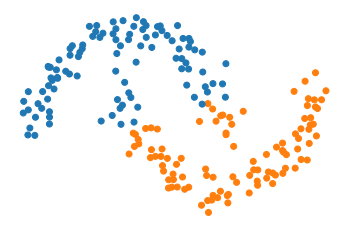

In [90]:
c = ['#1f77b4' if y_ == 0 else '#ff7f0e' for y_ in preds]
plt.axis('off')
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [56]:
import numpy as np

In [76]:
points = 20

min_X = np.min(X, axis=0)
max_X = np.max(X, axis=0)

X_0_points = np.linspace(min_X[0], max_X[0], points)
X_1_points = np.linspace(min_X[1], max_X[1], points)
X_pairs = np.array([(i, j) for i in X_0_points for j in X_1_points])

y_out = model_tf.predict(X_pairs)
predictions = np.argmax(y_out, axis=1)

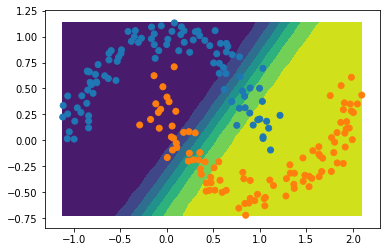

In [82]:
plt.contourf(*np.meshgrid(X_0_points, X_1_points), y_out[:, 0].reshape((points, points)))
plt.scatter(X[:, 0], X[:, 1], c=c)